In [654]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import logging
from time import sleep
import os
from dotenv import load_dotenv
import psycopg2
import pickle

In [655]:
pd.set_option('display.max_rows', 50)

In [656]:
pd.set_option('display.max_columns', None)

In [657]:
load_dotenv()
logger = logging.getLogger('pro_data_extraction')

import warnings
warnings.filterwarnings('ignore')

db_name = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')
password = os.getenv('POSTGRES_PASSWORD')
host = 'localhost'
port = '5432'

In [658]:
conn = psycopg2.connect(dbname=db_name, user=user, password=password, host=host, port=port)

In [659]:
cur = conn.cursor()

query = """
    SELECT 
        *
    FROM dota_ods.pro_matches_ml_full_v2
    WHERE allowed = True
"""

cur.execute(query)

rows = cur.fetchall()
df = pd.DataFrame(rows, columns=[desc[0] for desc in cur.description])

cur.close()
conn.close()

In [660]:
df.dropna(inplace=True)
df.head(5)

,match_data,match_id,league_id,allowed,radiant_team_id,dire_team_id,result,datetime,t1_games_last_12_months,t1_wins_last_12_months,t2_games_last_12_months,t2_wins_last_12_months,t1_games_last_3_months,t1_wins_last_3_months,t2_games_last_3_months,t2_wins_last_3_months,t1_games_last_2_weeks,t1_wins_last_2_weeks,t2_games_last_2_weeks,t2_wins_last_2_weeks,previous_games,previous_wins,team1_playerhero_kills,team1_playerhero_deaths,team1_playerhero_assists,team1_playerhero_games,team1_playerhero_winrate,team2_playerhero_kills,team2_playerhero_deaths,team2_playerhero_assists,team2_playerhero_games,team2_playerhero_winrate,team1_hero_kills,team1_hero_deaths,team1_hero_assists,team1_hero_games,team1_hero_winrate,team2_hero_kills,team2_hero_deaths,team2_hero_assists,team2_hero_games,team2_hero_winrate,team1_player_kills,team1_player_deaths,team1_player_assists,team1_player_games,team1_player_winrate,team2_player_kills,team2_player_deaths,team2_player_assists,team2_player_games,team2_player_winrate,avg_winrate_together_1,avg_winrate_together_2,avg_winrate_against_1,avg_winrate_against_2
0,"{'players': [{'account_id': 84853828, 'player_...",6792313267,14552,True,1061269,8686786,1,2022-10-05 23:55:30,123,72,151,51,63,36,81,28,19,11,21,8,6,4,5.658846,5.585769,10.866154,5.8000000000000000,0.541538,5.064286,5.137302,12.130952,5.0000000000000000,0.330952,5.581813,5.812747,12.089952,2019.8000000000000000,0.480151,6.139930,6.429057,12.790344,2387.4000000000000000,0.496997,6.330391,5.379776,11.868979,92.2000000000000000,0.534118,5.805568,4.697419,12.951034,164.6000000000000000,0.474913,0.526707,0.503187,0.509711,0.490289
1,"{'players': [{'account_id': 86822085, 'player_...",7210134665,14783,True,1061269,2672298,1,2023-06-21 22:59:22,203,116,135,74,72,48,40,23,10,10,16,8,7,1,7.090702,4.546491,15.150175,9.4000000000000000,0.420877,5.276667,6.321667,12.002500,11.2000000000000000,0.432500,6.828579,5.234668,10.815665,4532.6000000000000000,0.491369,5.886363,5.293142,11.847492,4791.2000000000000000,0.484467,6.065229,5.180758,13.231163,297.0000000000000000,0.468019,5.838490,6.298626,12.532111,241.0000000000000000,0.486308,0.485815,0.517011,0.507607,0.492393
2,"{'players': [{'account_id': 41231571, 'player_...",7210059273,15352,True,111474,8687717,1,2023-06-21 21:54:47,99,46,199,88,39,19,110,42,10,4,29,11,9,2,2.588095,4.951587,13.348413,4.4000000000000000,0.474603,5.679780,4.866017,10.502074,27.8000000000000000,0.394066,5.903153,5.276859,11.913501,3786.2000000000000000,0.487450,6.165708,6.036463,10.765090,4837.2000000000000000,0.487609,5.218532,4.919875,12.586470,130.6000000000000000,0.476078,5.553895,5.086175,12.532787,345.6000000000000000,0.454015,0.513937,0.471150,0.515444,0.484556
3,"{'players': [{'account_id': 320252024, 'player...",7209640238,15439,True,15,7422789,1,2023-06-21 16:57:01,200,133,217,86,78,50,108,46,26,17,29,14,3,1,4.817172,2.817980,12.596364,8.2000000000000000,0.530909,5.670927,4.743420,11.285043,27.0000000000000000,0.431675,6.052132,5.442679,11.648524,2822.0000000000000000,0.488796,5.701815,5.956469,11.962284,5323.8000000000000000,0.487918,5.008766,4.021391,11.641811,224.0000000000000000,0.479205,5.339705,4.890631,11.379058,304.6000000000000000,0.515368,0.520944,0.493556,0.499998,0.500002
4,"{'players': [{'account_id': 171211166, 'player...",6995237473,14859,True,1520578,6209804,0,2023-01-31 12:10:54,110,46,162,66,67,21,39,12,13,3,6,2,3,1,6.238889,5.788889,9.433333,7.4000000000000000,0.550000,3.362857,5.637143,7.374286,5.0000000000000000,0.528571,7.332265,5.069161,10.503079,2846.6000000000000000,0.483837,5.851014,6.631003,12.461338,3654.0000000000000000,0.485837,5.655332,6.385364,10.854154,205.6000000000000000,0.471243,5.370493,4.673359,11.579482,117.6000000000000000,0.480845,0.531283,0.503004,0.520065,0.479935


In [661]:
df.shape

(8803, 56)

In [662]:
df.columns

Index(['match_data', 'match_id', 'league_id', 'allowed', 'radiant_team_id',
       'dire_team_id', 'result', 'datetime', 't1_games_last_12_months',
       't1_wins_last_12_months', 't2_games_last_12_months',
       't2_wins_last_12_months', 't1_games_last_3_months',
       't1_wins_last_3_months', 't2_games_last_3_months',
       't2_wins_last_3_months', 't1_games_last_2_weeks',
       't1_wins_last_2_weeks', 't2_games_last_2_weeks', 't2_wins_last_2_weeks',
       'previous_games', 'previous_wins', 'team1_playerhero_kills',
       'team1_playerhero_deaths', 'team1_playerhero_assists',
       'team1_playerhero_games', 'team1_playerhero_winrate',
       'team2_playerhero_kills', 'team2_playerhero_deaths',
       'team2_playerhero_assists', 'team2_playerhero_games',
       'team2_playerhero_winrate', 'team1_hero_kills', 'team1_hero_deaths',
       'team1_hero_assists', 'team1_hero_games', 'team1_hero_winrate',
       'team2_hero_kills', 'team2_hero_deaths', 'team2_hero_assists',
       't

In [663]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

In [664]:
df_heroes = df[['datetime', 'match_data']]

In [665]:
df_heroes['year'] = df_heroes['datetime'].dt.year
df_heroes['month'] = df_heroes['datetime'].dt.month
df_heroes['day'] = df_heroes['datetime'].dt.day

In [666]:
all_hero_ids = set(range(1, 141))
for team_number in range(2):
    for hero_id in all_hero_ids:
            column_name = f'hero_{hero_id}_team_{team_number}'
            df_heroes[column_name] = df_heroes['match_data'].apply(lambda x: 1 if any(player.get('hero_id') == hero_id \
                                    and player.get('team_number') == team_number for player in x.get('players', {})) else 0)

In [667]:
df_heroes = df_heroes.drop(columns = ['match_data', 'datetime'])

In [668]:
df_heroes['result'] = df['result']

In [669]:
with open('models/heroes_xgb_pub.pkl', 'rb') as f:
    heroes_xgb_v1 = pickle.load(f)

In [670]:
df_heroes['proba'] = heroes_xgb_v1.predict_proba(df_heroes.drop(columns=['result']).values)[:, 1]

In [671]:
df['proba'] = df_heroes['proba']

In [672]:
df['target'] = df['result']

In [673]:
df_pred = df.drop(columns = ['match_data', 'match_id', 'radiant_team_id', 'dire_team_id', 'result', 'datetime'])

In [674]:
df_pred.head(5)

,league_id,allowed,t1_games_last_12_months,t1_wins_last_12_months,t2_games_last_12_months,t2_wins_last_12_months,t1_games_last_3_months,t1_wins_last_3_months,t2_games_last_3_months,t2_wins_last_3_months,t1_games_last_2_weeks,t1_wins_last_2_weeks,t2_games_last_2_weeks,t2_wins_last_2_weeks,previous_games,previous_wins,team1_playerhero_kills,team1_playerhero_deaths,team1_playerhero_assists,team1_playerhero_games,team1_playerhero_winrate,team2_playerhero_kills,team2_playerhero_deaths,team2_playerhero_assists,team2_playerhero_games,team2_playerhero_winrate,team1_hero_kills,team1_hero_deaths,team1_hero_assists,team1_hero_games,team1_hero_winrate,team2_hero_kills,team2_hero_deaths,team2_hero_assists,team2_hero_games,team2_hero_winrate,team1_player_kills,team1_player_deaths,team1_player_assists,team1_player_games,team1_player_winrate,team2_player_kills,team2_player_deaths,team2_player_assists,team2_player_games,team2_player_winrate,avg_winrate_together_1,avg_winrate_together_2,avg_winrate_against_1,avg_winrate_against_2,year,month,day,proba,target
0,14552,True,123,72,151,51,63,36,81,28,19,11,21,8,6,4,5.658846,5.585769,10.866154,5.8000000000000000,0.541538,5.064286,5.137302,12.130952,5.0000000000000000,0.330952,5.581813,5.812747,12.089952,2019.8000000000000000,0.480151,6.139930,6.429057,12.790344,2387.4000000000000000,0.496997,6.330391,5.379776,11.868979,92.2000000000000000,0.534118,5.805568,4.697419,12.951034,164.6000000000000000,0.474913,0.526707,0.503187,0.509711,0.490289,2022,10,5,0.592398,1
1,14783,True,203,116,135,74,72,48,40,23,10,10,16,8,7,1,7.090702,4.546491,15.150175,9.4000000000000000,0.420877,5.276667,6.321667,12.002500,11.2000000000000000,0.432500,6.828579,5.234668,10.815665,4532.6000000000000000,0.491369,5.886363,5.293142,11.847492,4791.2000000000000000,0.484467,6.065229,5.180758,13.231163,297.0000000000000000,0.468019,5.838490,6.298626,12.532111,241.0000000000000000,0.486308,0.485815,0.517011,0.507607,0.492393,2023,6,21,0.621209,1
2,15352,True,99,46,199,88,39,19,110,42,10,4,29,11,9,2,2.588095,4.951587,13.348413,4.4000000000000000,0.474603,5.679780,4.866017,10.502074,27.8000000000000000,0.394066,5.903153,5.276859,11.913501,3786.2000000000000000,0.487450,6.165708,6.036463,10.765090,4837.2000000000000000,0.487609,5.218532,4.919875,12.586470,130.6000000000000000,0.476078,5.553895,5.086175,12.532787,345.6000000000000000,0.454015,0.513937,0.471150,0.515444,0.484556,2023,6,21,0.729043,1
3,15439,True,200,133,217,86,78,50,108,46,26,17,29,14,3,1,4.817172,2.817980,12.596364,8.2000000000000000,0.530909,5.670927,4.743420,11.285043,27.0000000000000000,0.431675,6.052132,5.442679,11.648524,2822.0000000000000000,0.488796,5.701815,5.956469,11.962284,5323.8000000000000000,0.487918,5.008766,4.021391,11.641811,224.0000000000000000,0.479205,5.339705,4.890631,11.379058,304.6000000000000000,0.515368,0.520944,0.493556,0.499998,0.500002,2023,6,21,0.532673,1
4,14859,True,110,46,162,66,67,21,39,12,13,3,6,2,3,1,6.238889,5.788889,9.433333,7.4000000000000000,0.550000,3.362857,5.637143,7.374286,5.0000000000000000,0.528571,7.332265,5.069161,10.503079,2846.6000000000000000,0.483837,5.851014,6.631003,12.461338,3654.0000000000000000,0.485837,5.655332,6.385364,10.854154,205.6000000000000000,0.471243,5.370493,4.673359,11.579482,117.6000000000000000,0.480845,0.531283,0.503004,0.520065,0.479935,2023,1,31,0.363952,0


In [675]:
df_pred.columns

Index(['league_id', 'allowed', 't1_games_last_12_months',
       't1_wins_last_12_months', 't2_games_last_12_months',
       't2_wins_last_12_months', 't1_games_last_3_months',
       't1_wins_last_3_months', 't2_games_last_3_months',
       't2_wins_last_3_months', 't1_games_last_2_weeks',
       't1_wins_last_2_weeks', 't2_games_last_2_weeks', 't2_wins_last_2_weeks',
       'previous_games', 'previous_wins', 'team1_playerhero_kills',
       'team1_playerhero_deaths', 'team1_playerhero_assists',
       'team1_playerhero_games', 'team1_playerhero_winrate',
       'team2_playerhero_kills', 'team2_playerhero_deaths',
       'team2_playerhero_assists', 'team2_playerhero_games',
       'team2_playerhero_winrate', 'team1_hero_kills', 'team1_hero_deaths',
       'team1_hero_assists', 'team1_hero_games', 'team1_hero_winrate',
       'team2_hero_kills', 'team2_hero_deaths', 'team2_hero_assists',
       'team2_hero_games', 'team2_hero_winrate', 'team1_player_kills',
       'team1_player_deaths'

In [676]:
df_pred = df_pred[['year', 'month', 'day', 'league_id', 'allowed', 't1_games_last_12_months',
       't1_wins_last_12_months', 't2_games_last_12_months',
       't2_wins_last_12_months', 't1_games_last_3_months',
       't1_wins_last_3_months', 't2_games_last_3_months',
       't2_wins_last_3_months', 't1_games_last_2_weeks',
       't1_wins_last_2_weeks', 't2_games_last_2_weeks', 't2_wins_last_2_weeks',
       'previous_games', 'previous_wins', 'team1_playerhero_kills',
       'team1_playerhero_deaths', 'team1_playerhero_assists',
       'team1_playerhero_games', 'team1_playerhero_winrate',
       'team2_playerhero_kills', 'team2_playerhero_deaths',
       'team2_playerhero_assists', 'team2_playerhero_games',
       'team2_playerhero_winrate', 'team1_hero_kills', 'team1_hero_deaths',
       'team1_hero_assists', 'team1_hero_games', 'team1_hero_winrate',
       'team2_hero_kills', 'team2_hero_deaths', 'team2_hero_assists',
       'team2_hero_games', 'team2_hero_winrate', 'team1_player_kills',
       'team1_player_deaths', 'team1_player_assists', 'team1_player_games',
       'team1_player_winrate', 'team2_player_kills', 'team2_player_deaths',
       'team2_player_assists', 'team2_player_games', 'team2_player_winrate',
        'avg_winrate_together_1', 'avg_winrate_together_2', 'avg_winrate_against_1',
        'avg_winrate_against_2', 'proba', 'target']]

In [677]:
df_pred_train1 = df_pred.loc[df_pred['league_id'] != 15438].drop(columns = ['league_id', 'allowed'])

In [678]:
df_pred_test1 = df_pred.loc[df_pred['league_id'] == 15438].drop(columns = ['league_id', 'allowed'])

In [679]:
len(df_pred_train1)

8603

In [680]:
len(df_pred)

8803

In [681]:
len(df_pred_test1)

200

In [682]:
df_pred_test1.columns

Index(['year', 'month', 'day', 't1_games_last_12_months',
       't1_wins_last_12_months', 't2_games_last_12_months',
       't2_wins_last_12_months', 't1_games_last_3_months',
       't1_wins_last_3_months', 't2_games_last_3_months',
       't2_wins_last_3_months', 't1_games_last_2_weeks',
       't1_wins_last_2_weeks', 't2_games_last_2_weeks', 't2_wins_last_2_weeks',
       'previous_games', 'previous_wins', 'team1_playerhero_kills',
       'team1_playerhero_deaths', 'team1_playerhero_assists',
       'team1_playerhero_games', 'team1_playerhero_winrate',
       'team2_playerhero_kills', 'team2_playerhero_deaths',
       'team2_playerhero_assists', 'team2_playerhero_games',
       'team2_playerhero_winrate', 'team1_hero_kills', 'team1_hero_deaths',
       'team1_hero_assists', 'team1_hero_games', 'team1_hero_winrate',
       'team2_hero_kills', 'team2_hero_deaths', 'team2_hero_assists',
       'team2_hero_games', 'team2_hero_winrate', 'team1_player_kills',
       'team1_player_deaths'

In [683]:
X = df_pred_train1.drop(columns=['target']).values
y = df_pred_train1['target'].values

In [684]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7)

# param_grid = {
#     'n_estimators': [300, 400, 500, 600, 450],
#     'max_depth': [3, 4, 5, 6],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.1, 1],
#     'reg_alpha': [0.5]
# }

param_grid = {
    'n_estimators': [300],
    'max_depth': [4],
    'learning_rate': [0.05],
    'gamma': [1],
    'reg_alpha': [0.5]
}

In [695]:
xgb = XGBClassifier(tree_method = 'gpu_hist', use_label_encoder=False, eval_metric='logloss')

grid_search = GridSearchCV(xgb, param_grid, cv=10, scoring='roc_auc')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'gamma': [1], 'learning_rate': [0.05],
                         'max_depth': [4], 'n_estimators': [300],
                         'reg_alpha': [0.5]},
             scoring='roc_auc')

In [696]:
print(f"Best parameters: {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Best parameters: {'gamma': 1, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 0.5}
Accuracy: 0.627177700348432


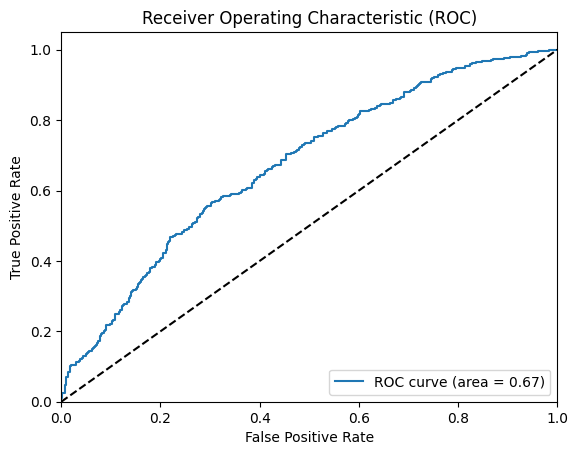

In [697]:
from sklearn.metrics import roc_curve, auc

y_score = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [698]:
grid_search.score(df_pred_test1.drop(columns = ['target']).values, df_pred_test1['target'].values)

0.5997

In [699]:
grid_search.predict_proba(df_pred_test1.drop(columns = ['target']).values).max(axis=1)

array([0.68046314, 0.5284019 , 0.611561  , 0.63510907, 0.5516868 ,
       0.5032516 , 0.6005759 , 0.66924196, 0.6036086 , 0.58514047,
       0.5028882 , 0.6053885 , 0.63713294, 0.80540377, 0.5305729 ,
       0.50370324, 0.572161  , 0.5005617 , 0.5088006 , 0.6526952 ,
       0.6274105 , 0.6735491 , 0.5293478 , 0.6515524 , 0.50148207,
       0.6493158 , 0.67145884, 0.58427215, 0.53196317, 0.5492769 ,
       0.5651444 , 0.562187  , 0.53891605, 0.5027853 , 0.61138964,
       0.5127928 , 0.61995965, 0.55024487, 0.58509535, 0.53705096,
       0.5559152 , 0.54925907, 0.50628656, 0.5650594 , 0.5975496 ,
       0.6811394 , 0.5939499 , 0.5571348 , 0.6269657 , 0.5115127 ,
       0.73187256, 0.71560764, 0.5518274 , 0.5602529 , 0.5803055 ,
       0.5071151 , 0.5681336 , 0.55437636, 0.59181035, 0.61142707,
       0.5311034 , 0.61006045, 0.5786065 , 0.6067269 , 0.629141  ,
       0.5395192 , 0.57783645, 0.581126  , 0.5266142 , 0.7564561 ,
       0.7425698 , 0.65055704, 0.5611173 , 0.71970797, 0.53745

In [700]:
df_wtf = df.loc[df['league_id'] == 15438]

In [701]:
df_wtf['predict'] = grid_search.predict(df_pred_test1.drop(columns = ['target']).values)

In [702]:
df_wtf['predict_proba'] = grid_search.predict_proba(df_pred_test1.drop(columns = ['target']).values).max(axis = 1)

In [703]:
df_wtf.tail(10)

,match_data,match_id,league_id,allowed,radiant_team_id,dire_team_id,result,datetime,t1_games_last_12_months,t1_wins_last_12_months,t2_games_last_12_months,t2_wins_last_12_months,t1_games_last_3_months,t1_wins_last_3_months,t2_games_last_3_months,t2_wins_last_3_months,t1_games_last_2_weeks,t1_wins_last_2_weeks,t2_games_last_2_weeks,t2_wins_last_2_weeks,previous_games,previous_wins,team1_playerhero_kills,team1_playerhero_deaths,team1_playerhero_assists,team1_playerhero_games,team1_playerhero_winrate,team2_playerhero_kills,team2_playerhero_deaths,team2_playerhero_assists,team2_playerhero_games,team2_playerhero_winrate,team1_hero_kills,team1_hero_deaths,team1_hero_assists,team1_hero_games,team1_hero_winrate,team2_hero_kills,team2_hero_deaths,team2_hero_assists,team2_hero_games,team2_hero_winrate,team1_player_kills,team1_player_deaths,team1_player_assists,team1_player_games,team1_player_winrate,team2_player_kills,team2_player_deaths,team2_player_assists,team2_player_games,team2_player_winrate,avg_winrate_together_1,avg_winrate_together_2,avg_winrate_against_1,avg_winrate_against_2,year,month,day,proba,target,predict,predict_proba
8226,"{'players': [{'account_id': 183719386, 'player...",7226093818,15438,True,8894818,15,0,2023-07-03 07:42:55,149,100,220,77,50,34,88,35,22,19,27,12,0,0,6.014504,4.039409,11.241682,30.2000000000000000,0.344250,5.048252,3.117483,14.167832,8.8000000000000000,0.215035,6.699555,5.571492,11.155343,6084.6000000000000000,0.485012,6.980730,5.420637,11.580668,4030.6000000000000000,0.487520,5.804959,4.615546,11.986967,333.6000000000000000,0.424784,4.911152,4.004747,11.459194,246.0000000000000000,0.472712,0.519583,0.506565,0.490464,0.509536,2023,7,3,0.315078,0,0,0.534109
8296,"{'players': [{'account_id': 156029808, 'player...",7220338538,15438,True,8254145,5,0,2023-06-29 06:08:28,224,123,90,47,63,29,45,23,1,0,1,0,1,0,5.141333,4.139556,10.240889,11.0000000000000000,0.400889,5.450000,3.900000,11.630952,4.2000000000000000,0.328571,6.400360,5.808003,11.626470,3558.4000000000000000,0.492720,6.447889,5.361653,10.972979,4917.4000000000000000,0.483567,5.727080,5.498545,12.048538,402.4000000000000000,0.473246,4.892231,4.904408,11.840060,162.2000000000000000,0.429034,0.546755,0.500230,0.521317,0.478683,2023,6,29,0.421881,0,0,0.588465
8399,"{'players': [{'account_id': 73562326, 'player_...",7234394896,15438,True,2163,8599101,1,2023-07-09 12:54:30,299,191,294,107,133,83,152,50,30,20,33,11,48,22,5.674359,4.883013,14.345192,13.6000000000000000,0.584295,5.274873,4.013618,10.552011,29.0000000000000000,0.557995,5.291116,5.854861,13.548700,4816.6000000000000000,0.492074,5.637374,6.039327,11.363562,4838.0000000000000000,0.485158,5.554773,4.556986,13.089967,347.0000000000000000,0.471210,4.894435,4.392574,11.530544,397.0000000000000000,0.505956,0.545142,0.499964,0.525428,0.474572,2023,7,9,0.591216,1,1,0.679049
8414,"{'players': [{'account_id': 148215639, 'player...",7224774802,15438,True,6209166,8254145,1,2023-07-02 10:53:13,255,142,234,109,106,50,69,40,25,10,13,9,6,5,5.283333,4.064167,12.625833,14.6000000000000000,0.462500,5.070476,5.782857,11.404762,12.0000000000000000,0.457143,5.960651,5.307160,11.657817,5777.2000000000000000,0.488025,5.858462,5.696305,11.114187,3127.0000000000000000,0.495247,4.946475,4.199113,11.374126,341.0000000000000000,0.454420,5.679868,5.500080,11.991804,414.4000000000000000,0.466736,0.509777,0.495634,0.519986,0.480014,2023,7,2,0.673225,1,1,0.618365
8464,"{'players': [{'account_id': 185908355, 'player...",7220611149,15438,True,8574561,8255888,1,2023-06-29 12:42:26,73,50,159,64,26,15,90,34,3,2,28,9,1,0,4.994872,5.342564,13.738462,6.0000000000000000,0.534359,4.904487,3.344872,8.860256,10.4000000000000000,0.301923,6.069011,5.439873,11.963935,3990.6000000000000000,0.488982,6.165289,5.961706,12.850938,3920.0000000000000000,0.491533,5.527394,4.496713,11.618235,163.6000000000000000,0.432900,6.007010,3.699938,11.007015,244.2000000000000000,0.427124,0.564147,0.507928,0.503388,0.496612,2023,6,29,0.628813,1,0,0.544839
86

In [704]:
df_wtf2 = df_wtf[['predict', 'predict_proba', 'target', 'proba', 'match_data', 'match_id', 'datetime', 'radiant_team_id', 'dire_team_id']]

In [705]:
df_wtf2.loc[df_wtf2['dire_team_id'] == 39]

,predict,predict_proba,target,proba,match_data,match_id,datetime,radiant_team_id,dire_team_id
900,0,0.649316,0,0.428824,"{'players': [{'account_id': 156029808, 'player...",7222989370,2023-07-01 05:00:06,8254145,39
901,0,0.671459,1,0.578647,"{'players': [{'account_id': 156029808, 'player...",7223052578,2023-07-01 06:29:40,8254145,39
997,1,0.531963,1,0.789932,"{'players': [{'account_id': 54580962, 'player_...",7220296489,2023-06-29 05:03:47,2163,39
2510,1,0.568134,1,0.644135,"{'players': [{'account_id': 321580662, 'player...",7224537050,2023-07-02 06:21:27,7119388,39
3499,1,0.512747,1,0.726290,"{'players': [{'account_id': 94281932, 'player_...",7226256930,2023-07-03 11:53:58,8668460,39
3562,0,0.701987,0,0.498979,"{'players': [{'account_id': 202217968, 'player...",7224738368,2023-07-02 10:22:19,5,39
3854,0,0.751630,1,0.419366,"{'players': [{'account_id': 1171243748, 'playe...",7230010951,2023-07-06 09:30:50,8254400,39
3999,0,0.543721,1,0.393747,"{'players': [{'account_id': 10366616, 'player_...",7221630397,2023-06-30 05:04:56,8291895,39
5519,0,0.554157,1,0.493953,"{'players': [{'account_id': 148215639, 'player...",7223229523,2023-07-01 10:12:53,6209166,39
5520,0,0.514726,1,0.761705,"{'players': [{'account_id': 148215639, 'player...",7223318461,2023-07-01 11:42:27,6209166,39


In [706]:
y

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [707]:
df_wtf2.loc[df_wtf2['predict'] != df_wtf2['target']]

,predict,predict_proba,target,proba,match_data,match_id,datetime,radiant_team_id,dire_team_id
20,1,0.680463,0,0.653708,"{'players': [{'account_id': 86745912, 'player_...",7230110109,2023-07-06 11:57:26,39,8254400
26,1,0.528402,0,0.672943,"{'players': [{'account_id': 148215639, 'player...",7220315256,2023-06-29 05:22:10,6209166,7119388
77,1,0.551687,0,0.482762,"{'players': [{'account_id': 185908355, 'player...",7230231689,2023-07-06 14:12:12,8574561,8255888
96,1,0.600576,0,0.675010,"{'players': [{'account_id': 87063175, 'player_...",7224643004,2023-07-02 08:37:41,8728920,8599101
97,1,0.669242,0,0.684411,"{'players': [{'account_id': 87063175, 'player_...",7226108950,2023-07-03 08:16:08,8728920,8574561
...,...,...,...,...,...,...,...,...,...
8023,1,0.594143,0,0.521807,"{'players': [{'account_id': 292921272, 'player...",7223447315,2023-07-01 13:47:06,8255756,8894818
8165,1,0.665269,0,0.334496,"{'players': [{'account_id': 124801257, 'player...",7223148170,2023-07-01 08:40:09,8255888,15
8464,0,0.544839,1,0.628813,"{'players': [{'account_id': 185908355, 'player...",7220611149,2023-06-29 12:42:26,8574561,8255888
8605,1,0.593349,0,0.839109,"{'players': [{'account_id': 185908355, 'player...",7221741719,2023-06-30 08:00:01,8574561,7422789


In [708]:
df_wtf2.sort_values(by='datetime')

,predict,predict_proba,target,proba,match_data,match_id,datetime,radiant_team_id,dire_team_id
5283,1,0.702901,1,0.460042,"{'players': [{'account_id': 10366616, 'player_...",7220296983,2023-06-29 05:01:26,8291895,8254400
49,0,0.611561,0,0.616582,"{'players': [{'account_id': 156029808, 'player...",7220299602,2023-06-29 05:01:42,8254145,5
997,1,0.531963,1,0.789932,"{'players': [{'account_id': 54580962, 'player_...",7220296489,2023-06-29 05:03:47,2163,39
26,1,0.528402,0,0.672943,"{'players': [{'account_id': 148215639, 'player...",7220315256,2023-06-29 05:22:10,6209166,7119388
7830,1,0.567873,1,0.456749,"{'players': [{'account_id': 86745912, 'player_...",7220336186,2023-06-29 06:06:20,39,2163
...,...,...,...,...,...,...,...,...,...
7455,1,0.513350,0,0.613343,"{'players': [{'account_id': 10366616, 'player_...",7234063473,2023-07-09 07:10:22,8291895,2163
4302,1,0.522783,1,0.411354,"{'players': [{'account_id': 91730177, 'player_...",7234263112,2023-07-09 11:00:06,8599101,2163
8399,1,0.679049,1,0.591216,"{'players': [{'account_id': 73562326, 'player_...",7234394896,2023-07-09 12:54:30,2163,8599101
1476,0,0.537051,1,0.451346,"{'players': [{'account_id': 91730177, 'player_...",7234512983,2023-07-09 14:18:52,8599101,2163


In [709]:
best_model = grid_search.best_estimator_

importances = best_model.feature_importances_

feature_names = df_pred_train1.drop('target', axis=1).columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values('Importance', ascending=False)

print(importance_df)

                   Feature  Importance
43     team2_player_deaths    0.035408
8    t1_wins_last_3_months    0.031794
38     team1_player_deaths    0.031646
40      team1_player_games    0.030024
49   avg_winrate_against_1    0.029173
..                     ...         ...
33       team2_hero_deaths    0.014443
47  avg_winrate_together_1    0.014123
29      team1_hero_assists    0.012817
28       team1_hero_deaths    0.012346
0                     year    0.003871

[52 rows x 2 columns]


In [710]:
grid_search.score(X_test, y_test)

0.6717093186480942

In [711]:
df_gg = df_wtf2[['predict', 'target', 'predict_proba']]

In [719]:
len(df_gg.loc[df_gg['predict_proba'] > 0.5])

200

In [720]:
len(df_gg.loc[(df_gg['predict'] != df_gg['target']) & (df_gg['predict_proba'] > 0.5)])

82

In [714]:
len(df_gg.loc[(df_gg['predict'] != df_gg['target'])])

82

In [721]:
with open('models/teams_model.pkl', 'rb') as f:
    teams = pickle.load(f)

In [723]:
teams.score(df_pred_test1.drop(columns = ['target', 'avg_winrate_together_1', 'avg_winrate_together_2',
       'avg_winrate_against_1', 'avg_winrate_against_2']).values, df_pred_test1['target'].values)

0.6738